In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import re 
import ast
import warnings
warnings.filterwarnings('ignore')

# Compute accuracy

In [2]:
# Define the file path for human ratings dataset
human_ratings_path = "./data/explica/explica_freq_4800.tsv"

# Load the human ratings dataset into a pandas DataFrame
human_ratings = pd.read_csv(human_ratings_path, sep=",")
# Sort the dataset based on multiple columns to ensure a consistent order
# Sorting by 'pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', and 'tested_order'
# helps in maintaining consistency for further analysis
human_ratings = human_ratings.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order'])



In [3]:
import ast
import pandas as pd

def get_model_max_rating_cat(batch_df_sub, desc):
    """
    Determines the connective (word/phrase linking sentences) chosen by humans and models based on different rating criteria.
    
    Parameters:
        batch_df_sub (pd.DataFrame): Subset of the dataset containing sentence pairs and ratings.
        desc (str): Description specifying the evaluation method ('acc' for acceptability, 'mc' for multiple choice, 
                    'perpl' for perplexity, 'cloze' for cloze test).
    
    Returns:
        pd.DataFrame: Updated DataFrame with the human and model-chosen connectives.
    """
    
    # Assign the connective preferred by humans (from precomputed data)
    batch_df_sub['human_chosen_connective'] = batch_df_sub['human_preferred_connective_unrel']

    ##### COMPUTE THE CONNECTIVE CHOSEN BY MODELS
    # Acceptability-Based Selection
    if "acc" in desc:  # Select the connective with the highest rating
        batch_df_sub['model_chosen_connective'] = batch_df_sub.groupby('pair_id')['answer_greedy_cleaned'].transform(
            lambda x: batch_df_sub.loc[x.idxmax(), 'tested_connective']
        )

    # Multiple Choice-Based Selection
    elif "mc" in desc:  # Map the model-generated answer to the corresponding choice in the dictionary
        generated = batch_df_sub["answer_greedy_cleaned"].tolist()
        choices = [eval(x) for x in batch_df_sub["answers_dict"].tolist()]
        chosen_connective = []
        
        for generation, ans_dict in zip(generated, choices):
            if generation not in ans_dict:
                chosen_connective.append("error")  # Handle cases where the model's choice is not found
            else:
                chosen_connective.append(ans_dict[generation])
        
        batch_df_sub["model_chosen_connective"] = chosen_connective

    # Perplexity-Based Selection
    elif "perpl" in desc:  # Select the connective corresponding to the lowest perplexity ranking
        batch_df_sub['model_chosen_connective'] = batch_df_sub.groupby('pair_id')['rank'].transform(
            lambda x: batch_df_sub.loc[x.idxmin(), 'tested_connective']
        )

    # Cloze Test-Based Selection
    elif "cloze" in desc:  # Directly take the model-generated answer
        batch_df_sub['model_chosen_connective'] = batch_df_sub['answer_greedy_cleaned']
    
    # Remove duplicate rows to ensure uniqueness
    batch_df_sub_unique = batch_df_sub.drop_duplicates()
    
    return batch_df_sub_unique


def split_sentence_pairs(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the dataset into two DataFrames based on different sentence orders.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing sentence pairs.
    
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: Two DataFrames representing different sentence orders.
    """
    
    # Group by sentence pair identifier
    grouped = df.groupby("pair_id")

    df_order_1 = []
    df_order_2 = []

    for _, group in grouped:
        if len(group) == 8:  # Ensuring that each pair appears exactly 8 times (4 per order)
            order_1 = group.iloc[:4]  # First 4 rows for one order
            order_2 = group.iloc[4:]  # Last 4 rows for the reverse order
            df_order_1.append(order_1)
            df_order_2.append(order_2)

    # Concatenating results into two separate DataFrames
    df_order_1 = pd.concat(df_order_1)
    df_order_2 = pd.concat(df_order_2)

    return df_order_1, df_order_2


def clean_compute_max(batch_df, desc):
    """
    Prepares and processes the dataset to determine the most preferred connective for each sentence pair.
    
    Parameters:
        batch_df (pd.DataFrame): The full dataset containing sentence pairs and model predictions.
        desc (str): Description specifying the evaluation method.
    
    Returns:
        pd.DataFrame: Final dataset sorted by pair_id, containing model-selected connectives.
    """

    # Split the dataset into two groups based on different sentence orders
    batch_df_order_1, batch_df_order_2 = split_sentence_pairs(batch_df)
    
    # Compute the preferred connective for each order
    batch_df_BA_unique = get_model_max_rating_cat(batch_df_order_1, desc)
    batch_df_AB_unique = get_model_max_rating_cat(batch_df_order_2, desc)
    
    # Combine the results
    batches = [batch_df_AB_unique, batch_df_BA_unique]
    df = pd.concat(batches)
    
    # Sort results by pair_id for consistency
    df = df.sort_values(['pair_id'])
    
    return df


In [4]:
import ast
import pandas as pd

def compute_accuracy(desc, _dict, accuracies, human_ratings):
    """
    Compute the accuracy of model predictions compared to human ratings.
    
    Parameters:
        desc (str): Description of the evaluation method ('mc' for multiple choice, 'cloze' for cloze test, etc.).
        _dict (dict): Dictionary mapping model names to file paths.
        accuracies (dict): Dictionary to store computed accuracy values.
        human_ratings (pd.DataFrame): DataFrame containing human ratings.
    
    Returns:
        dict: Updated accuracies dictionary with computed accuracy values.
    """
    
    print("Task:", desc)
    for model, path in _dict.items():
        print("Model:", model)
        
        df_curr = pd.read_csv(path, sep="\t")
        
        # Prepare a dictionary to store accuracies for the current model
        key = desc + "_" + model
        accuracies[key] = dict()
        
        # Standardize the dataset format
        if "mc" in desc:  # Multiple-choice format has a different order representation
            order_map = {'<A;B>': "B follows A", '<B;A>': "A follows B", 'none': 'none'}
            df_curr['order'] = df_curr['order'].map(order_map)
            df_curr = df_curr.drop_duplicates(subset=["Sentence_A", "Sentence_B"], keep="first")
        # Standardize column names
        df_curr["tested_relation"] = df_curr.pop("relation")
        df_curr["tested_order"] = df_curr.pop("order")
        df_curr["tested_connective"] = df_curr.pop("conn_in_list")
        
        if "true_connective" in df_curr.columns:
            df_curr["connective"] = df_curr.pop("true_connective")
        if "conn_in_list" in df_curr.columns:
            df_curr["conn_in_sent"] = df_curr.pop("conn_in_list")
        
        # Sort dataset for consistency
        df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective'])
        
        # Merge with human ratings based on evaluation type
        if "mc" in desc:
            df_curr_with_human = pd.merge(
                human_ratings, 
                df_curr[['pair_id', 'Sentence_A', 'Sentence_B', 'generated_answer_outlines', 'answer_greedy_cleaned', 'answers_dict']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B']
            )
        elif "cloze" in desc:
            df_curr_with_human = pd.merge(
                human_ratings, 
                df_curr[['pair_id', 'Sentence_A', 'Sentence_B', 'generated_answer_outlines', 'answer_greedy_cleaned']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B']
            )
        else:
            df_curr_with_human = pd.merge(
                df_curr, 
                human_ratings[['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective', 'order_human', 'relation_human', 'condition_human', 'human_preferred_connective_unrel']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective']
            )
        
        # Compute accuracy
        df_human_gt = clean_compute_max(df_curr_with_human, desc)
        
        # Filter dataset into different categories based on order and relation
        df_human_gt_caus_AB = df_human_gt[(df_human_gt['order_human'] == "A,B") & (df_human_gt['relation_human'] == "Causal")]
        df_human_gt_temp_AB = df_human_gt[(df_human_gt['order_human'] == "A,B") & (df_human_gt['relation_human'] == "Temporal")]
        df_human_gt_caus_BA = df_human_gt[(df_human_gt['order_human'] == "B,A") & (df_human_gt['relation_human'] == "Causal")]
        df_human_gt_temp_BA = df_human_gt[(df_human_gt['order_human'] == "B,A") & (df_human_gt['relation_human'] == "Temporal")]
        
        # Compute overall accuracy
        total = pd.concat([df_human_gt_caus_AB, df_human_gt_temp_AB, df_human_gt_caus_BA, df_human_gt_temp_BA])
        correct = total[total['human_preferred_connective_unrel'] == total["model_chosen_connective"]].shape[0]
        accuracy_total = correct / total.shape[0]
        accuracies[key]["Overall"] = accuracy_total
        
        # Compute accuracy per category
        dfs = {
            "Causality AB": df_human_gt_caus_AB,
            "Temporal AB": df_human_gt_temp_AB,
            "Causality BA": df_human_gt_caus_BA,
            "Temporal BA": df_human_gt_temp_BA,
        }
        
        for k, v in dfs.items():
            correct = v[v['human_preferred_connective_unrel'] == v["model_chosen_connective"]].shape[0]
            accuracy = correct / v.shape[0]
            accuracies[key][k] = accuracy
        
    return accuracies


In [5]:
accuracies = dict()
###########******* ACCEPTABILITY RATINGS TASK


acc_few_dict = {
"gpt4o" : "./data/res/acceptability/fewshot/raw/accept_res_outlines_gpt-4o_few_cleaned.tsv",    
"falcon" : "./data/res/acceptability/fewshot/raw/accept_res_outlines_falcon-7b-instruct_cleaned.tsv",
"gemma" : "./data/res/acceptability/fewshot/raw/accept_res_outlines_gemma-2-9b-it_cleaned.tsv",
"llama" : "./data/res/acceptability/fewshot/raw/accept_res_outlines_Meta-Llama-3.1-8B-Instruct_cleaned.tsv",
"mistral" : "./data/res/acceptability/fewshot/raw/accept_res_outlines_Mistral-7B-Instruct-v0.3_cleaned.tsv",
"qwen" : "./data/res/acceptability/fewshot/raw/accept_res_outlines_Qwen2.5-7B-Instruct_cleaned.tsv" }


accuracies = compute_accuracy("acc_few", acc_few_dict, accuracies, human_ratings)


###########

acc_zero_dict = {
"gpt4omini" : "./data/res/acceptability/zeroshot/raw/accept_res_outlines_gpt-4o-mini_zero_cleaned.tsv",
"gpt4o" : "./data/res/acceptability/zeroshot/raw/accept_res_outlines_gpt-4o_zero_cleaned.tsv",    
"falcon" : "./data/res/acceptability/zeroshot/raw/accept_res_outlines_falcon-7b-instruct_cleaned.tsv",
"gemma" : "./data/res/acceptability/zeroshot/raw/accept_res_outlines_gemma-2-9b-it_cleaned.tsv",
"llama" : "./data/res/acceptability/zeroshot/raw/accept_res_outlines_Meta-Llama-3.1-8B-Instruct_cleaned.tsv",
"mistral" : "./data/res/acceptability/zeroshot/raw/accept_res_outlines_Mistral-7B-Instruct-v0.3_cleaned.tsv",
"qwen" : "./data/res/acceptability/zeroshot/raw/accept_res_outlines_Qwen2.5-7B-Instruct_cleaned.tsv" }

accuracies = compute_accuracy("acc_zero", acc_zero_dict, accuracies, human_ratings)

###########******* CLOZE TEST TASK

cloze_few_dict = {
    "gpt4omini": "./data/res/cloze/fewshot/raw/cloze_res_outlines_gpt-4o-mini_few_cleaned.tsv",
    "gpt4o": "./data/res/cloze/fewshot/raw/cloze_res_outlines_gpt-4o_few_cleaned.tsv",
    "falcon": "./data/res/cloze/fewshot/raw/cloze_res_outlines_falcon-7b-instruct_cleaned.tsv",
    "gemma": "./data/res/cloze/fewshot/raw/cloze_res_outlines_gemma-2-9b-it_cleaned.tsv",
    "llama": "./data/res/cloze/fewshot/raw/cloze_res_outlines_Meta-Llama-3.1-8B-Instruct_cleaned.tsv",
    "mistral": "./data/res/cloze/fewshot/raw/cloze_res_outlines_Mistral-7B-Instruct-v0.3_cleaned.tsv",
    "qwen": "./data/res/cloze/fewshot/raw/cloze_res_outlines_Qwen2.5-7B-Instruct_cleaned.tsv"
}

accuracies = compute_accuracy("cloze_few", cloze_few_dict, accuracies, human_ratings)


###########


cloze_zero_dict = {
  "gpt4omini": "./data/res/cloze/zeroshot/raw/cloze_res_outlines_gpt-4o-mini_zero_cleaned.tsv",
    "gpt4o": "./data/res/cloze/zeroshot/raw/cloze_res_outlines_gpt-4o_zero_cleaned.tsv",
    "falcon": "./data/res/cloze/zeroshot/raw/cloze_res_outlines_falcon-7b-instruct_cleaned.tsv",
    "gemma": "./data/res/cloze/zeroshot/raw/cloze_res_outlines_gemma-2-9b-it_cleaned.tsv",
    "llama": "./data/res/cloze/zeroshot/raw/cloze_res_outlines_Meta-Llama-3.1-8B-Instruct_cleaned.tsv",
    "mistral": "./data/res/cloze/zeroshot/raw/cloze_res_outlines_Mistral-7B-Instruct-v0.3_cleaned.tsv",
    "qwen": "./data/res/cloze/zeroshot/raw/cloze_res_outlines_Qwen2.5-7B-Instruct_cleaned.tsv"
}


accuracies = compute_accuracy("cloze_zero", cloze_zero_dict, accuracies, human_ratings)


###########******* MULTIPLE CHOICE TASK




mc_few_dict = {
     "gpt4omini": "./data/res/mc/fewshot/raw/mult_choice_res_outlines_gpt-4o-mini_few_cleaned.tsv",
    "gpt4o": "./data/res/mc/fewshot/raw/mult_choice_res_outlines_gpt-4o_few_cleaned.tsv",
    "falcon": "./data/res/mc/fewshot/raw/res_multiple_choice-falcon-7b-instruct-connective_cleaned.tsv",
    "gemma": "./data/res/mc/fewshot/raw/res_multiple_choice-gemma-2-9b-it-connective_cleaned.tsv",
    "llama": "./data/res/mc/fewshot/raw/res_multiple_choice-Meta-Llama-3.1-8B-Instruct-connective_cleaned.tsv",
    "mistral": "./data/res/mc/fewshot/raw/res_multiple_choice-Mistral-7B-Instruct-v0.3-connective_cleaned.tsv",
    "qwen": "./data/res/mc/fewshot/raw/res_multiple_choice-Qwen2.5-7B-Instruct-connective_cleaned.tsv"
}

accuracies = compute_accuracy("mc_few", mc_few_dict, accuracies, human_ratings)

########

mc_zero_dict = {
   "gpt4omini": "./data/res/mc/zeroshot/raw/mult_choice_res_outlines_gpt-4o-mini_cleaned.tsv",
    "gpt4o": "./data/res/mc/zeroshot/raw/mult_choice_res_outlines_gpt-4o_cleaned.tsv",
    "falcon": "./data/res/mc/zeroshot/raw/res_multiple_choice-falcon-7b-instruct-connective_cleaned.tsv",
    "gemma": "./data/res/mc/zeroshot/raw/res_multiple_choice-gemma-2-9b-it-connective_cleaned.tsv",
    "llama": "./data/res/mc/zeroshot/raw/res_multiple_choice-Meta-Llama-3.1-8B-Instruct-connective_cleaned.tsv",
    "mistral": "./data/res/mc/zeroshot/raw/res_multiple_choice-Mistral-7B-Instruct-v0.3-connective_cleaned.tsv",
    "qwen": "./data/res/mc/zeroshot/raw/res_multiple_choice-Qwen2.5-7B-Instruct-connective_cleaned.tsv"
}



accuracies = compute_accuracy("mc_zero", mc_zero_dict, accuracies, human_ratings)

###########******* PERPLEXITY

perpl_dict = {
    "falcon": "./data/res/perplexity/falcon-7b-instruct.csv",
    "gemma": "./data/res/perplexity/gemma-2-9b-it.csv",
    "llama": "./data/res/perplexity/Meta-Llama-3.1-8B-Instruct.csv",
    "mistral": "./data/res/perplexity/Mistral-7B-Instruct-v0.3.csv",
    "qwen": "./data/res/perplexity/Qwen2.5-7B-Instruct.csv"

}


accuracies = compute_accuracy("perpl", perpl_dict, accuracies, human_ratings)





Task: acc_few
Model: gpt4o
Model: falcon
Model: gemma
Model: llama
Model: mistral
Model: qwen
Task: acc_zero
Model: gpt4omini
Model: gpt4o
Model: falcon
Model: gemma
Model: llama
Model: mistral
Model: qwen
Task: cloze_few
Model: gpt4omini
Model: gpt4o
Model: falcon
Model: gemma
Model: llama
Model: mistral
Model: qwen
Task: cloze_zero
Model: gpt4omini
Model: gpt4o
Model: falcon
Model: gemma
Model: llama
Model: mistral
Model: qwen
Task: mc_few
Model: gpt4omini
Model: gpt4o
Model: falcon
Model: gemma
Model: llama
Model: mistral
Model: qwen
Task: mc_zero
Model: gpt4omini
Model: gpt4o
Model: falcon
Model: gemma
Model: llama
Model: mistral
Model: qwen
Task: perpl
Model: falcon
Model: gemma
Model: llama
Model: mistral
Model: qwen


In [7]:
accuracies

{'acc_few_gpt4o': {'Overall': 0.7841981132075472,
  'Causality AB': 0.8341463414634146,
  'Temporal AB': 0.8,
  'Causality BA': 0.7442922374429224,
  'Temporal BA': 0.75},
 'acc_few_falcon': {'Overall': 0.2016509433962264,
  'Causality AB': 0.00975609756097561,
  'Temporal AB': 0.0,
  'Causality BA': 0.0319634703196347,
  'Temporal BA': 0.9878048780487805},
 'acc_few_gemma': {'Overall': 0.5094339622641509,
  'Causality AB': 0.424390243902439,
  'Temporal AB': 0.4115384615384615,
  'Causality BA': 0.4977168949771689,
  'Temporal BA': 0.7865853658536586},
 'acc_few_llama': {'Overall': 0.3266509433962264,
  'Causality AB': 0.7609756097560976,
  'Temporal AB': 0.23076923076923078,
  'Causality BA': 0.1004566210045662,
  'Temporal BA': 0.23780487804878048},
 'acc_few_mistral': {'Overall': 0.24646226415094338,
  'Causality AB': 0.12682926829268293,
  'Temporal AB': 0.023076923076923078,
  'Causality BA': 0.1004566210045662,
  'Temporal BA': 0.9451219512195121},
 'acc_few_qwen': {'Overall': 0

## Results averaged for each model

In [8]:
import numpy as np

# Provided data
data = accuracies

# Function to compute the mean and standard deviation for "few" and "zero" tasks per model
def compute_means_and_std(data):
    mean_few = {}
    mean_zero = {}
    std_few = {}
    std_zero = {}
    few = {}
    zero = {}
    
    for key, values in data.items():
        if "7" not in key and "qwen" in key:
            continue
        
        for metric, value in values.items():
            if metric == "Overall":
                if 'perpl' in key:
                    continue
                
                model = key.split('_')[2]  # Extract model name from key
                task_type = key.split('_')[1]  # Extract task type (few/zero)
                
                # Store values for mean and standard deviation calculation
                if task_type == 'few':
                    few.setdefault(model, []).append(value)
                elif task_type == 'zero':
                    zero.setdefault(model, []).append(value)
    
    # Compute mean and standard deviation for each model
    for model in few:
        mean_few[model] = np.mean(few[model])
        std_few[model] = np.std(few[model])
        mean_zero[model] = np.mean(zero[model])
        std_zero[model] = np.std(zero[model])
        
    return mean_few, mean_zero, std_few, std_zero

# Compute means and standard deviations
mean_few, mean_zero, std_few, std_zero = compute_means_and_std(data)

# Display results
print("Mean per model (Few):")
for model, mean in mean_few.items():
    print(f"{model}: {mean:.4f}, Std. Dev: {std_few.get(model, 0):.4f}")

print("\nMean per model (Zero):")
for model, mean in mean_zero.items():
    print(f"{model}: {mean:.4f}, Std. Dev: {std_zero.get(model, 0):.4f}")


Mean per model (Few):
gpt4o: 0.6667, Std. Dev: 0.1092
falcon: 0.1486, Std. Dev: 0.1065
gemma: 0.1753, Std. Dev: 0.2364
llama: 0.2347, Std. Dev: 0.1672
mistral: 0.3793, Std. Dev: 0.1019
gpt4omini: 0.2718, Std. Dev: 0.2683

Mean per model (Zero):
gpt4o: 0.5542, Std. Dev: 0.1112
falcon: 0.1372, Std. Dev: 0.0977
gemma: 0.2630, Std. Dev: 0.2468
llama: 0.3027, Std. Dev: 0.2184
mistral: 0.2795, Std. Dev: 0.1133
gpt4omini: 0.3860, Std. Dev: 0.2752


## Results averaged for each task

In [9]:

# Provided data
data = accuracies

def compute_means_and_std(data):
    few, zero = {}, {}
    for key, values in data.items():
        if "7" not in key and "qwen" in key:
            continue
        if "Overall" in values and 'perpl' not in key:
            model, task_type = key.split('_')[2], key.split('_')[1]
            (few if task_type == 'few' else zero).setdefault(model, []).append(values["Overall"])
    
    return {
        "mean_few": {m: np.mean(v) for m, v in few.items()},
        "std_few": {m: np.std(v) for m, v in few.items()},
        "mean_zero": {m: np.mean(v) for m, v in zero.items()},
        "std_zero": {m: np.std(v) for m, v in zero.items()}
    }

stats = compute_means_and_std(data)

tasks = ["acc_few", "acc_zero", "mc_few", "mc_zero", "cloze_few", "cloze_zero", "perpl"]
best_average_task, best_average_task_nogpt, best_average_task_onlygpt = {}, {}, {}

def categorize_accuracies():
    for key, values in accuracies.items():
        for task in tasks:
            if task in key:
                best_average_task.setdefault(task, []).append(values["Overall"])
                (best_average_task_onlygpt if "gpt" in key else best_average_task_nogpt).setdefault(task, []).append(values["Overall"])

categorize_accuracies()

few_all, few_open, few_gpt, zero_all, zero_open, zero_gpt = [], [], [], [], [], []
for task, values in best_average_task.items():
    mean_all, std_all = np.mean(values), np.std(values)
    mean_nogpt, std_nogpt = np.mean(best_average_task_nogpt.get(task, [0])), np.std(best_average_task_nogpt.get(task, [0]))
    mean_gpt, std_gpt = np.mean(best_average_task_onlygpt.get(task, [0])), np.std(best_average_task_onlygpt.get(task, [0]))
    
    print(f"{task}\t{round(mean_all, 2)} ({round(std_all, 2)})\t{round(mean_nogpt, 2)} ({round(std_nogpt, 2)})\t{round(mean_gpt, 2)} ({round(std_gpt, 2)})")
    
    if "few" in task:
        few_all.extend(values)
        few_open.extend(best_average_task_nogpt.get(task, []))
        few_gpt.extend(best_average_task_onlygpt.get(task, []))
    elif "zero" in task:
        zero_all.extend(values)
        zero_open.extend(best_average_task_nogpt.get(task, []))
        zero_gpt.extend(best_average_task_onlygpt.get(task, []))

print(f"FEW\t{round(np.mean(few_all), 2)} ({round(np.std(few_all), 2)})\t{round(np.mean(few_open), 2)} ({round(np.std(few_open), 2)})\t{round(np.mean(few_gpt), 2)} ({round(np.std(few_gpt), 2)})")
print(f"ZERO\t{round(np.mean(zero_all), 2)} ({round(np.std(zero_all), 2)})\t{round(np.mean(zero_open), 2)} ({round(np.std(zero_open), 2)})\t{round(np.mean(zero_gpt), 2)} ({round(np.std(zero_gpt), 2)})")


acc_few	0.42 (0.2)	0.35 (0.12)	0.78 (0.0)
acc_zero	0.49 (0.17)	0.43 (0.16)	0.66 (0.03)
cloze_few	0.42 (0.21)	0.34 (0.19)	0.62 (0.08)
cloze_zero	0.38 (0.13)	0.32 (0.09)	0.54 (0.01)
mc_few	0.2 (0.24)	0.18 (0.22)	0.26 (0.26)
mc_zero	0.15 (0.2)	0.13 (0.19)	0.21 (0.21)
perpl	0.63 (0.02)	0.63 (0.02)	0.0 (0.0)
FEW	0.34 (0.24)	0.29 (0.2)	0.51 (0.27)
ZERO	0.34 (0.22)	0.29 (0.2)	0.47 (0.23)


## From dictionary to pandas dataframe

In [10]:
# Convert the dictionary into a DataFrame
# Use the outer keys as 'Model' and expand the inner dictionaries into columns
df = pd.DataFrame.from_dict(accuracies, orient='index')

# Reset the index and rename the index column to 'Model'
#df.reset_index(inplace=True)
df.rename(columns={'index': 'Model'}, inplace=True)


In [11]:
df

,Overall,Causality AB,Temporal AB,Causality BA,Temporal BA
acc_few_gpt4o,0.784198,0.834146,0.800000,0.744292,0.750000
acc_few_falcon,0.201651,0.009756,0.000000,0.031963,0.987805
acc_few_gemma,0.509434,0.424390,0.411538,0.497717,0.786585
acc_few_llama,0.326651,0.760976,0.230769,0.100457,0.237805
acc_few_mistral,0.246462,0.126829,0.023077,0.100457,0.945122
acc_few_qwen,0.476415,0.497561,0.361538,0.557078,0.524390
acc_zero_gpt4omini,0.634434,0.634146,0.584615,0.625571,0.725610
acc_zero_gpt4o,0.692217,0.775610,0.715385,0.716895,0.518293
acc_zero_falcon,0.191038,0.029268,0.003846,0.045662,0.884146
acc_zero_gemma,0.593160,0.697561,0.380769,0.515982,0.902439


# Plot the accuracies

## Plot the overall results

In [12]:
palette = [
    
    # Purples 
    '#ffb7db',  # Soft pink
    '#faa0d5',  # Pale pink
    '#e75480',  # Pink
    '#d4b3f5',  # Light purple
    '#c693f0',  # Lavender
    '#b973eb',  # Medium purple
    '#9370DB',  # Original medium purple
    '#8A2BE2',  # Original lavender
    '#731ad5',  # Deep purple
    '#663399',  # Original Rebecca purple
    '#5a0ec7',  # Strong purple
    '#4B0082',  # Original indigo
    '#3d006f',  # Dark indigo
    '#30005c',  # Deep indigo
    
    # Greens 
    '#caffd5',  # Pastel yellow-green
    '#b4ecc8',  # Light green
    '#afffbb',  # Light yellow-green
    '#9df2a3',  # Soft green-yellow
    '#82e0aa',  # Original light green
    '#66d893',  # Medium green
    '#6ae07a',  # Yellow-green
    '#4caf50',  # Original medium green
    '#3b8f44',  # Forest green
    '#2ca02c',  # Original green
    '#1d8348',  # Original dark forest green
    '#176f3a',  # Darker green
    '#115b2d',  # Deep forest green
    '#0c4720',  # Almost black green
    
    # Reds 
    '#fcd8c7',  # Light pastel orange
    '#faa0a0',  # Light salmon red
    '#f4a261',  # Soft orange
    '#fac4a4',  # Pastel orange
    '#f1948a',  # Original light red
    '#f17c54',  # Light orange-red
    '#eb6e6e',  # Medium light red
    '#d62728',  # Original red
    '#e34a2b',  # Orange-red
    '#c0392b',  # Original strong red
    '#a93226',  # Original dark red
    '#8a2620',  # Darker red
    '#6c1d1a',  # Deep dark red
    '#4d1413',  # Very dark red
    
    # Blues 
    '#1f77b4',  # Blue (
    '#5dade2',  # Light blue 
    '#4a91e3',  # Medium blue 
    '#003f5c',  # Dark navy blue 
    '#1d5ea8',  # Dark azure 
]

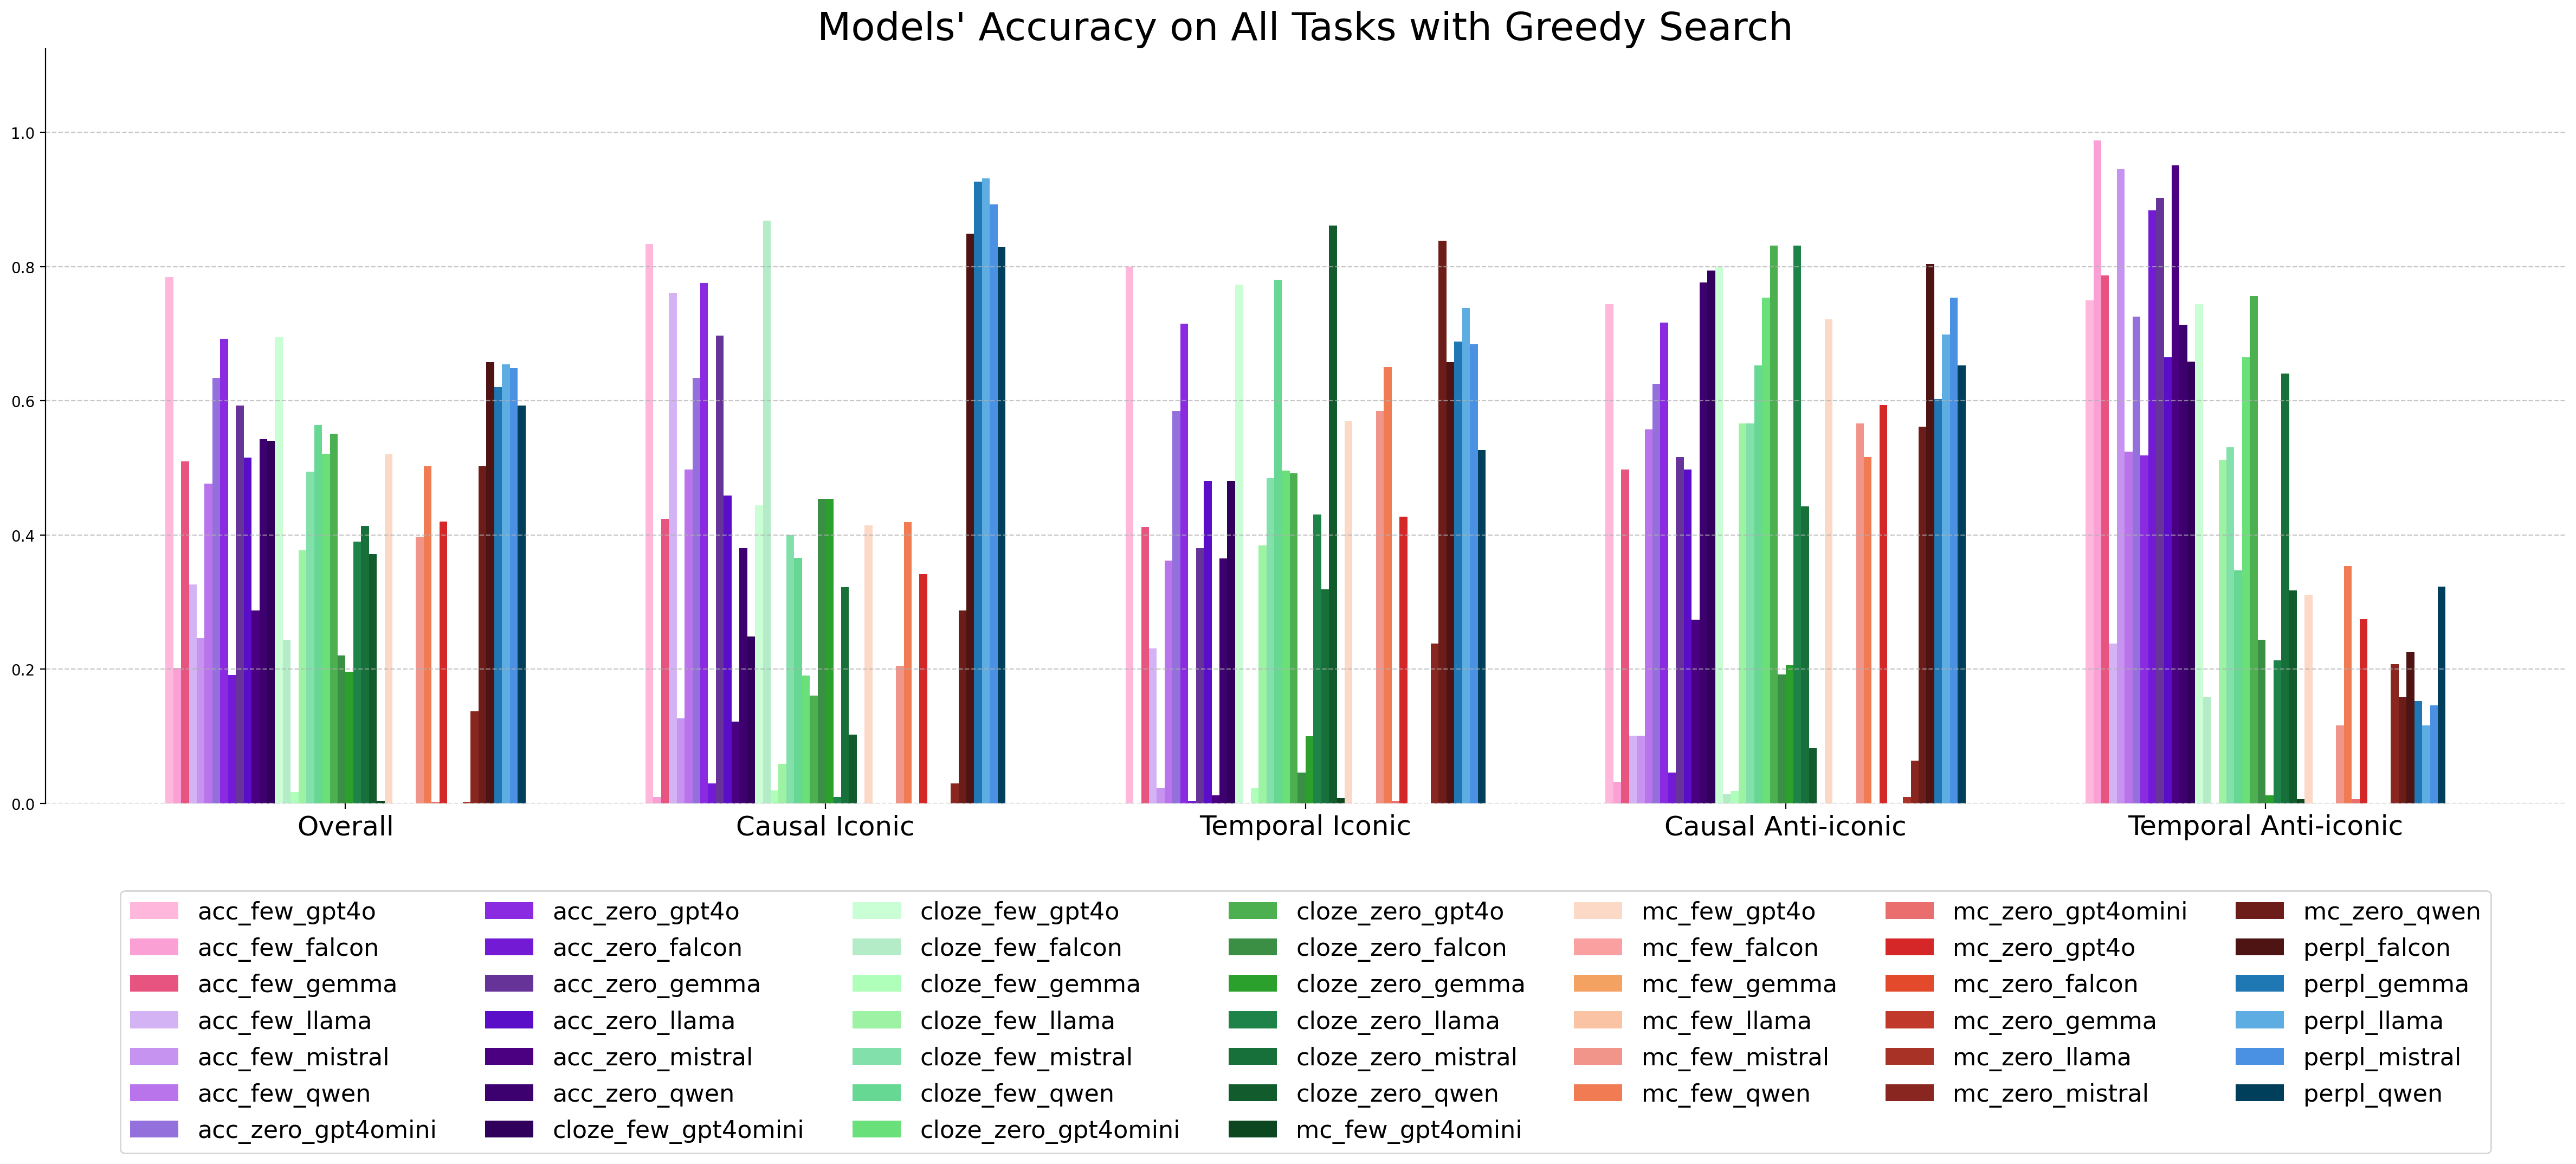

In [13]:
%config InlineBackend.figure_format='retina'  # Ensure high-resolution figures for better visualization


# Dictionary mapping task identifiers to their readable labels
group_labels = {
    "acc_few": "Accuracy - Few",
    "acc_zero": "Accuracy - Zero",
    "cloze_few": "Cloze - Few",
    "cloze_zero": "Cloze - Zero",
    "mc_few_mc_zer": "MC - Few & Zero",
    "perpl": "Perplexity"
}

# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(30, 12))

# Transpose the dataframe and plot as a bar chart
df.T.plot.bar(ax=ax, color=palette, rot=0, ylim=(0, 1.125), width=0.75)

# Dictionary defining labels for x-axis categories
group_answer_dict = {
    "Overall": "",
    "Causality AB": ('Causal', 'Iconic', "SO"),
    "Temporal AB": ('Temporal', 'Iconic', "THEN"),
    "Causality BA": ('Causal', 'Anti-iconic', "BECAUSE"),
    "Temporal BA": ('Temporal', 'Anti-iconic', "AFTER")
}

# Set custom x-axis labels based on the dictionary mapping
ax.set_xticklabels([
    f"{group_answer_dict[item][0]} {group_answer_dict[item][1]}"
    if isinstance(group_answer_dict[item], tuple) else item 
    for item in df.T.index.tolist()
], fontsize=18)

# Customize the plot borders (spines) to improve readability
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)

# Extract legend handles and labels for grouping
handles, labels = ax.get_legend_handles_labels()

# Organize legend entries into categorized groups
from collections import defaultdict
legend_dict = defaultdict(list)
for handle, label in zip(handles, labels):
    for key in group_labels:
        if key in label:
            legend_dict[group_labels[key]].append(handle)

# Adjust figure layout to accommodate the legend below the chart
fig.subplots_adjust(bottom=0.3)

# Add grid lines to improve readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Set the title of the plot
ax.set_title("Models' Accuracy on All Tasks with Greedy Search", fontsize=26)

# Display the legend at the bottom of the figure
ax.legend(
    handles, labels,
    loc='upper center', bbox_to_anchor=(0.5, -0.1), 
    ncol=7,
    fontsize=16,
)

# Show the final plot
plt.show()


## Plot a subset of the results

In [14]:
# Create a subset of the 'accuracies' dictionary containing results of specific models for plotting
subset = {}

# List of target models to filter results
models = ["gpt4o", "falcon", "gemma"]

# Iterate through the 'accuracies' dictionary
for task, value in accuracies.items():
    model_name = ""

    # Filter entries for GPT-4o model (excluding "mini" variations)
    if "gpt4o" in task and "mini" not in task:
        model_name = "GPT4o "
        if "acc" in task and "zero" in task:
            model_name += "Acc. Rat."  # Accuracy rate for zero-shot learning
            subset[model_name] = value

    # Filter entries for Falcon model
    elif "falcon" in task:
        model_name = "Falcon "
        if "acc" in task and "zero" in task:
            model_name += "Acc. Rat."
            subset[model_name] = value
        elif "perpl" in task:
            model_name += "AP score"  # Perplexity score
            subset[model_name] = value

    # Filter entries for Gemma model
    elif "gemma" in task:
        model_name = "Gemma "
        if "acc" in task and "zero" in task:
            model_name += "Acc. Rat."
            subset[model_name] = value
        elif "perpl" in task:
            model_name += "AP score"
            subset[model_name] = value

# Convert the subset dictionary into a DataFrame for further analysis
df = pd.DataFrame.from_dict(subset, orient='index')

# Rename the index column to 'Model' for clarity
df.rename(columns={'index': 'Model'}, inplace=True)

# Display the DataFrame
df


,Overall,Causality AB,Temporal AB,Causality BA,Temporal BA
GPT4o Acc. Rat.,0.692217,0.775610,0.715385,0.716895,0.518293
Falcon Acc. Rat.,0.191038,0.029268,0.003846,0.045662,0.884146
Gemma Acc. Rat.,0.593160,0.697561,0.380769,0.515982,0.902439
Falcon AP score,0.658019,0.848780,0.657692,0.803653,0.225610
Gemma AP score,0.620283,0.926829,0.688462,0.602740,0.152439


In [15]:
palette = [
'#4caf50',  # Original medium green,
'#176f3a',  # Darker green
'#5dade2',  # Light blue (accept_hf_zero_prob_0-9_llama3.1)
'#eb6e6e',  # Medium light red
'#a93226',  # Original dark red
    
          ]

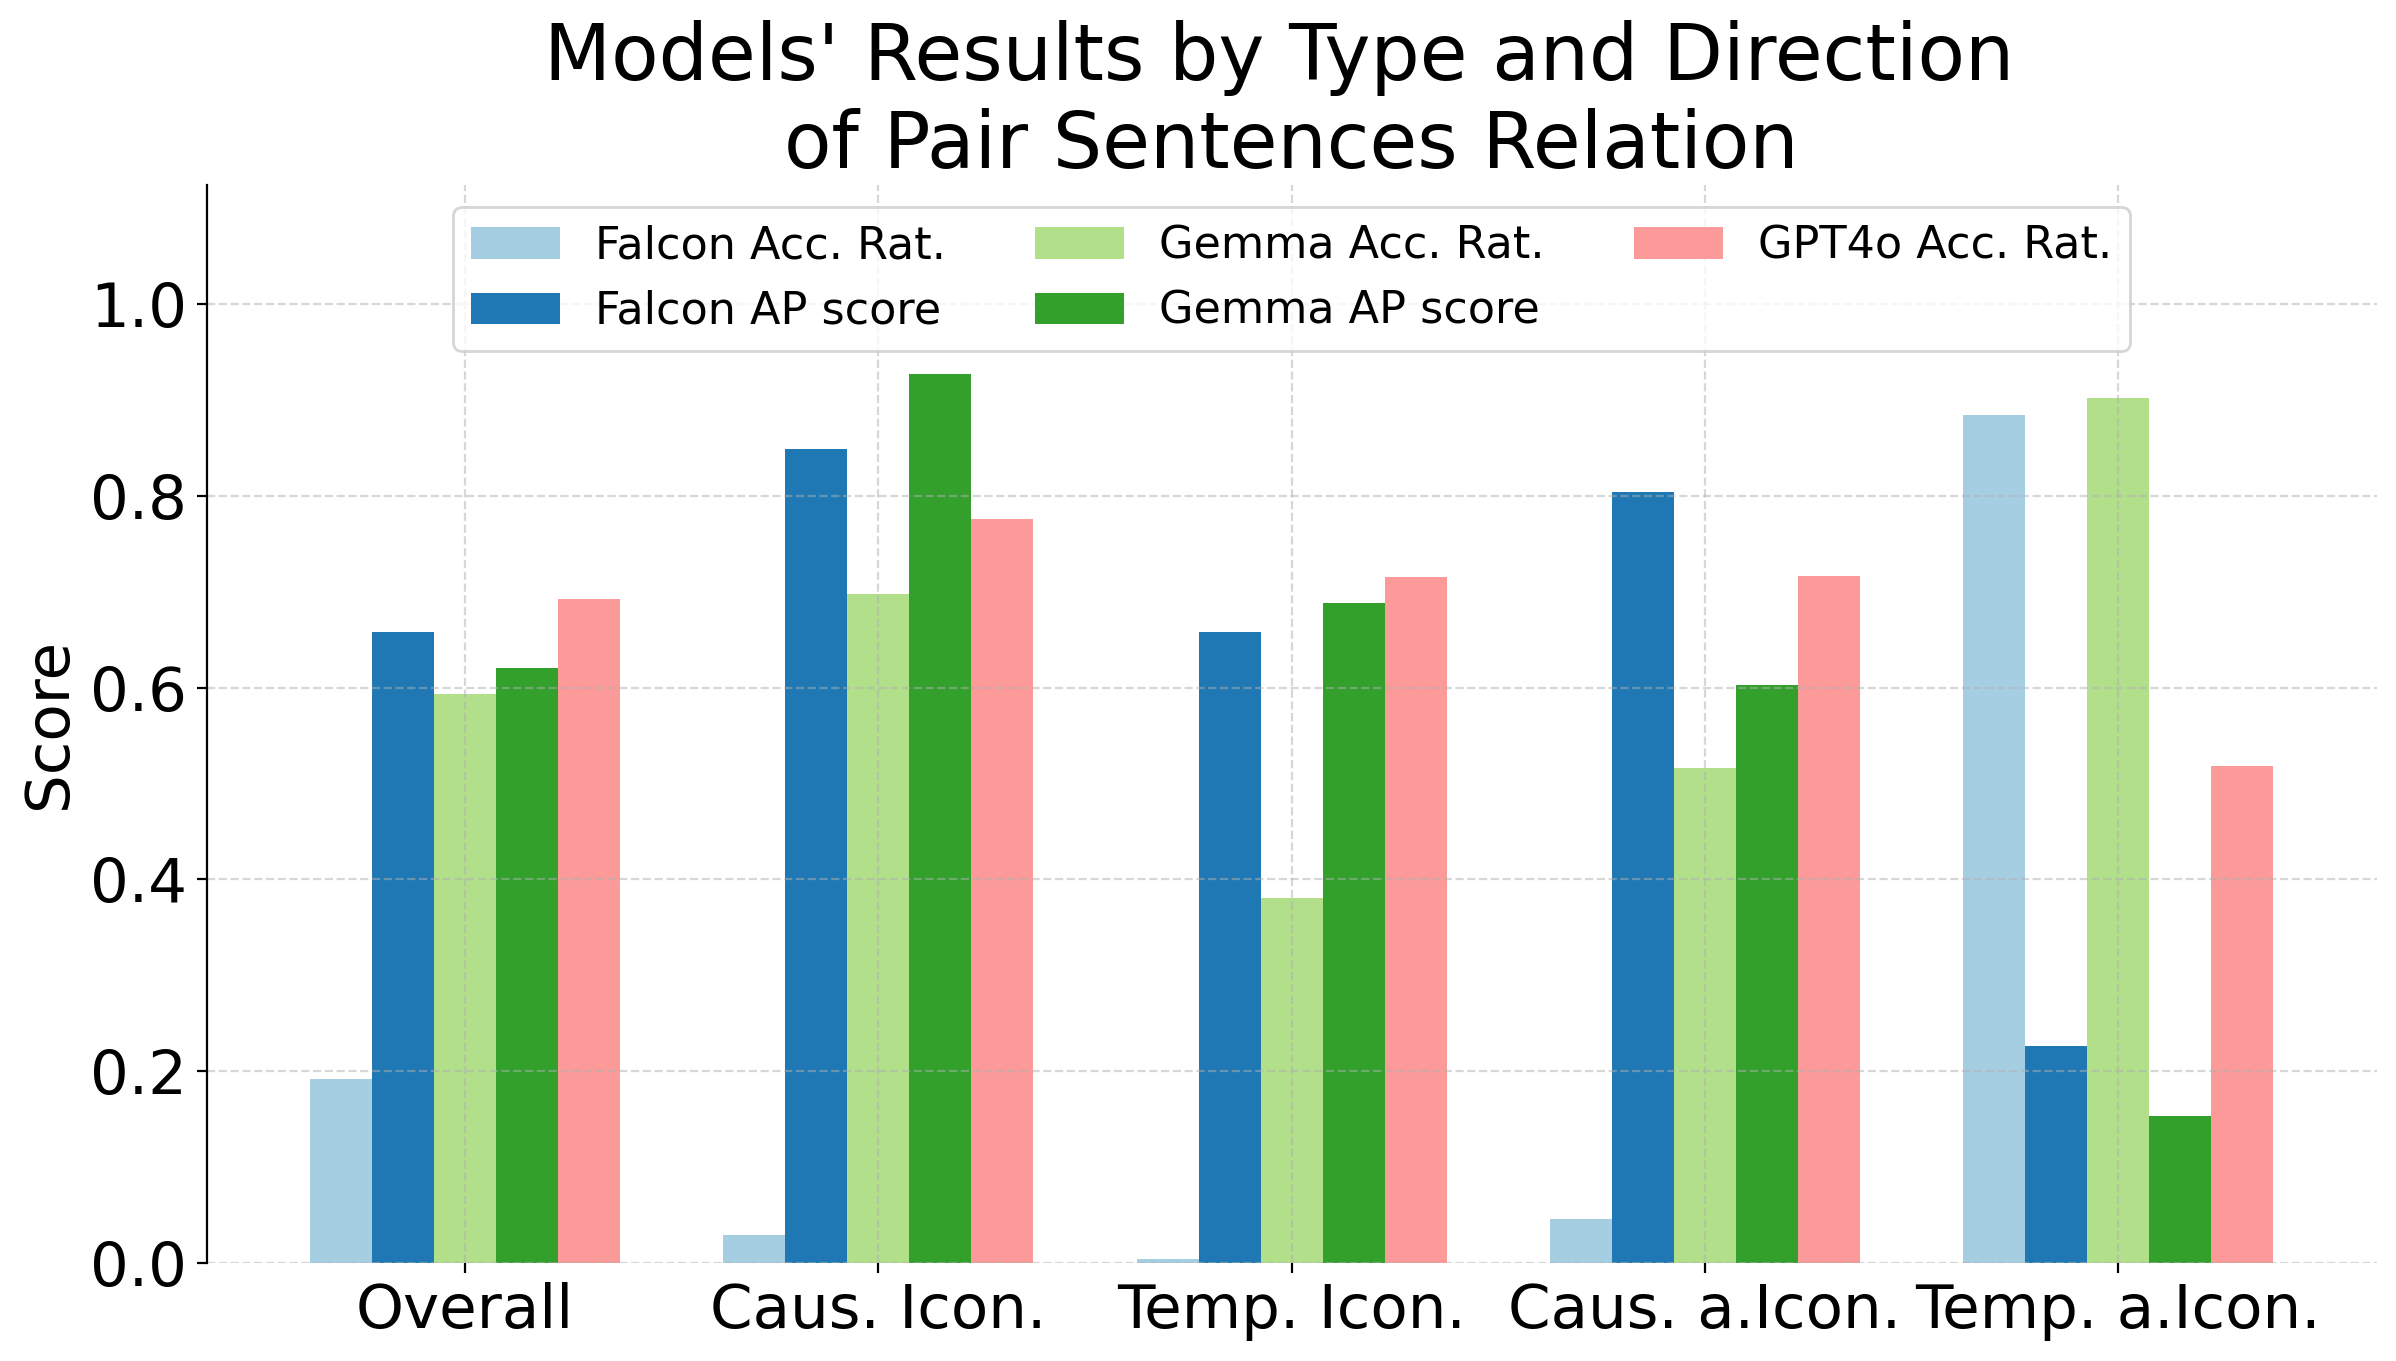

In [16]:
# Set high-resolution output for inline figures in Jupyter Notebook
%config InlineBackend.figure_format = 'retina'

# Set global font size for all plots
plt.rcParams.update({'font.size': 22})

# Define a color palette for the bar plot
palette = sns.color_palette("Paired")

# Define the custom order of models for better visualization
model_order = ["Falcon Acc. Rat.", "Falcon AP score", 
               "Gemma Acc. Rat.", "Gemma AP score", 
               "GPT4o Acc. Rat."]

# Transpose the DataFrame to match the desired format
df = df.T

# Reorder columns based on the predefined model order
df = df[model_order]

# Create a bar plot to visualize the model performance
fig = df.plot.bar(figsize=(14, 7),   # Set figure size
                  color=palette,     # Apply color palette
                  rot=0,             # Keep x-axis labels horizontal
                  ylim=(0, 1.125),   # Set y-axis limits
                  ylabel='Score',    # Label for y-axis
                  width=0.75)        # Adjust bar width

# Dictionary to map index values to their respective labels
group_answer_dict = {
    "Overall": "",
    "Causality AB": ('Caus.', 'Icon.', "SO"),
    "Temporal AB": ('Temp.', 'Icon.', "THEN"),
    "Causality BA": ('Caus.', 'a.Icon.', "BECAUSE"),
    "Temporal BA": ('Temp.', 'a.Icon.', "AFTER")                  
}

# Modify x-axis labels for clarity, handling tuple-based values
fig.set_xticklabels(
    [f"{group_answer_dict[item][0]} {group_answer_dict[item][1]}" 
     if isinstance(group_answer_dict[item], tuple) else item 
     for item in df.index.tolist()], 
    fontsize=22
)

# Adjusting the visibility of plot borders (spines)
fig.spines['right'].set_visible(False)
fig.spines['top'].set_visible(False)
fig.spines['left'].set_visible(True)
fig.spines['bottom'].set_visible(False)

# Add a light grid to improve readability
plt.grid(True, linestyle='--', alpha=0.5)

# Set the plot title with appropriate font size
plt.title("Models' Results by Type and Direction \nof Pair Sentences Relation", fontsize=28)

# Display the legend in an upper-centered position with three columns
plt.legend(loc='upper center', ncols=3, fontsize=16)

# Show the final plot
plt.show()
